In [6]:
import os
work_dir = 'pbmc_tutorial'
tmp_dir = '/cellar/users/aklie/tmp/'

In [2]:
import scanpy as sc
adata = sc.read_h5ad(os.path.join(work_dir, 'scRNA/adata.h5ad'))
scRNA_bc = adata.obs_names
cell_data = adata.obs
cell_data['sample_id'] = '10x_pbmc'
cell_data['celltype'] = cell_data['celltype'].astype(str) # set data type of the celltype column to str, otherwise the export_pseudobulk function will complain.
del(adata)

In [7]:
import pickle
fragments_dict = {'10x_pbmc': os.path.join(work_dir, 'data/pbmc_granulocyte_sorted_3k_atac_fragments.tsv.gz')}
path_to_regions = {'10x_pbmc':os.path.join(work_dir, 'scATAC/consensus_peak_calling/consensus_regions.bed')}
path_to_blacklist= os.path.join(work_dir, 'hg38-blacklist.v2.bed')
metadata_bc = pickle.load(open(os.path.join(work_dir, 'scATAC/quality_control/metadata_bc.pkl'), 'rb'))
bc_passing_filters = pickle.load(open(os.path.join(work_dir, 'scATAC/quality_control/bc_passing_filters.pkl'), 'rb'))

In [4]:
print(f"{len(list(set(bc_passing_filters['10x_pbmc']) & set(scRNA_bc)))} cell barcodes pass both scATAC-seq and scRNA-seq based filtering")

2418 cell barcodes pass both scATAC-seq and scRNA-seq based filtering


In [8]:
from pycisTopic.cistopic_class import *
key = '10x_pbmc'
cistopic_obj = create_cistopic_object_from_fragments(
                            path_to_fragments=fragments_dict[key],
                            path_to_regions=path_to_regions[key],
                            path_to_blacklist=path_to_blacklist,
                            metrics=metadata_bc[key],
                            valid_bc=list(set(bc_passing_filters[key]) & set(scRNA_bc)),
                            n_cpu=1,
                            project=key,
                            split_pattern='-')
cistopic_obj.add_cell_data(cell_data, split_pattern='-')
print(cistopic_obj)

2023-01-02 13:14:51,812 cisTopic     INFO     Reading data for 10x_pbmc
2023-01-02 13:16:05,589 cisTopic     INFO     metrics provided!
2023-01-02 13:16:08,942 cisTopic     INFO     valid_bc provided, selecting barcodes!
2023-01-02 13:16:12,056 cisTopic     INFO     Counting fragments in regions
2023-01-02 13:16:38,735 cisTopic     INFO     Creating fragment matrix
2023-01-02 13:17:03,682 cisTopic     INFO     Converting fragment matrix to sparse matrix
2023-01-02 13:17:08,864 cisTopic     INFO     Removing blacklisted regions
2023-01-02 13:17:10,886 cisTopic     INFO     Creating CistopicObject
2023-01-02 13:17:12,159 cisTopic     INFO     Done!
Columns ['sample_id'] will be overwritten
CistopicObject from project 10x_pbmc with n_cells × n_regions = 2418 × 194203


In [9]:
pickle.dump(cistopic_obj,
            open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'wb'))

In [10]:
import pickle
cistopic_obj = pickle.load(open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'rb'))
from pycisTopic.cistopic_class import *
models=run_cgs_models(cistopic_obj,
                    n_topics=[2,4,10,16,32,48],
                    n_cpu=5,
                    n_iter=500,
                    random_state=555,
                    alpha=50,
                    alpha_by_topic=True,
                    eta=0.1,
                    eta_by_topic=False,
                    save_path=None,
                    _temp_dir = os.path.join(tmp_dir + 'ray_spill'))

2023-01-02 13:18:42,243	INFO worker.py:1519 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 


(run_cgs_model pid=102444) 2023-01-02 13:19:01,997 cisTopic     INFO     Running model with 2 topics
(run_cgs_model pid=102443) 2023-01-02 13:19:02,231 cisTopic     INFO     Running model with 4 topics
(run_cgs_model pid=102442) 2023-01-02 13:19:02,466 cisTopic     INFO     Running model with 10 topics
(run_cgs_model pid=102445) 2023-01-02 13:19:02,948 cisTopic     INFO     Running model with 32 topics
(run_cgs_model pid=102441) 2023-01-02 13:19:03,109 cisTopic     INFO     Running model with 16 topics
(run_cgs_model pid=102444) 2023-01-02 13:30:35,912 cisTopic     INFO     Model with 2 topics done!
(run_cgs_model pid=102444) 2023-01-02 13:30:36,019 cisTopic     INFO     Running model with 48 topics
(run_cgs_model pid=102443) 2023-01-02 13:37:38,530 cisTopic     INFO     Model with 4 topics done!
(run_cgs_model pid=102442) 2023-01-02 13:56:11,290 cisTopic     INFO     Model with 10 topics done!
(run_cgs_model pid=102441) 2023-01-02 14:11:25,739 cisTopic     INFO     Model with 16 topic

In [11]:
if not os.path.exists(os.path.join(work_dir, 'scATAC/models')):
    os.makedirs(os.path.join(work_dir, 'scATAC/models'))

pickle.dump(models,
            open(os.path.join(work_dir, 'scATAC/models/10x_pbmc_models_500_iter_LDA.pkl'), 'wb'))

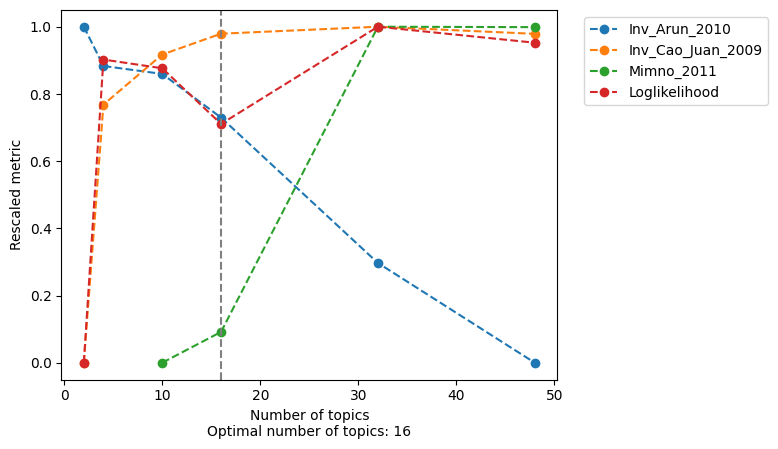

In [12]:
models = pickle.load(open(os.path.join(work_dir, 'scATAC/models/10x_pbmc_models_500_iter_LDA.pkl'), 'rb'))
cistopic_obj = pickle.load(open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'rb'))
from pycisTopic.lda_models import *
model = evaluate_models(models,
                       select_model=16,
                       return_model=True,
                       metrics=['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
                       plot_metrics=False)

In [13]:
cistopic_obj.add_LDA_model(model)
pickle.dump(cistopic_obj,
            open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'wb'))

2023-01-02 16:53:46,784 cisTopic     INFO     Running UMAP


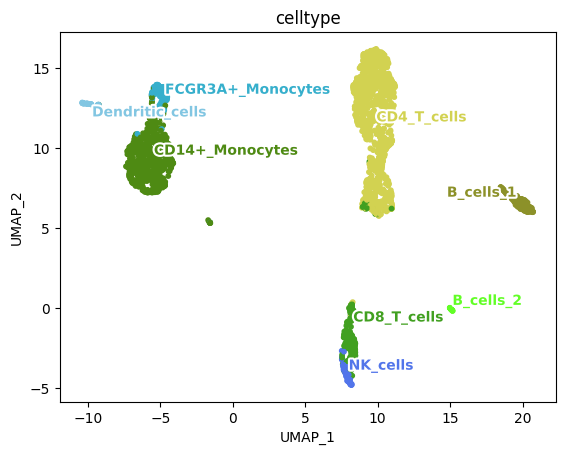

In [14]:
from pycisTopic.clust_vis import *
run_umap(cistopic_obj, target  = 'cell', scale=True)
plot_metadata(cistopic_obj, reduction_name = 'UMAP', variables = ['celltype'])

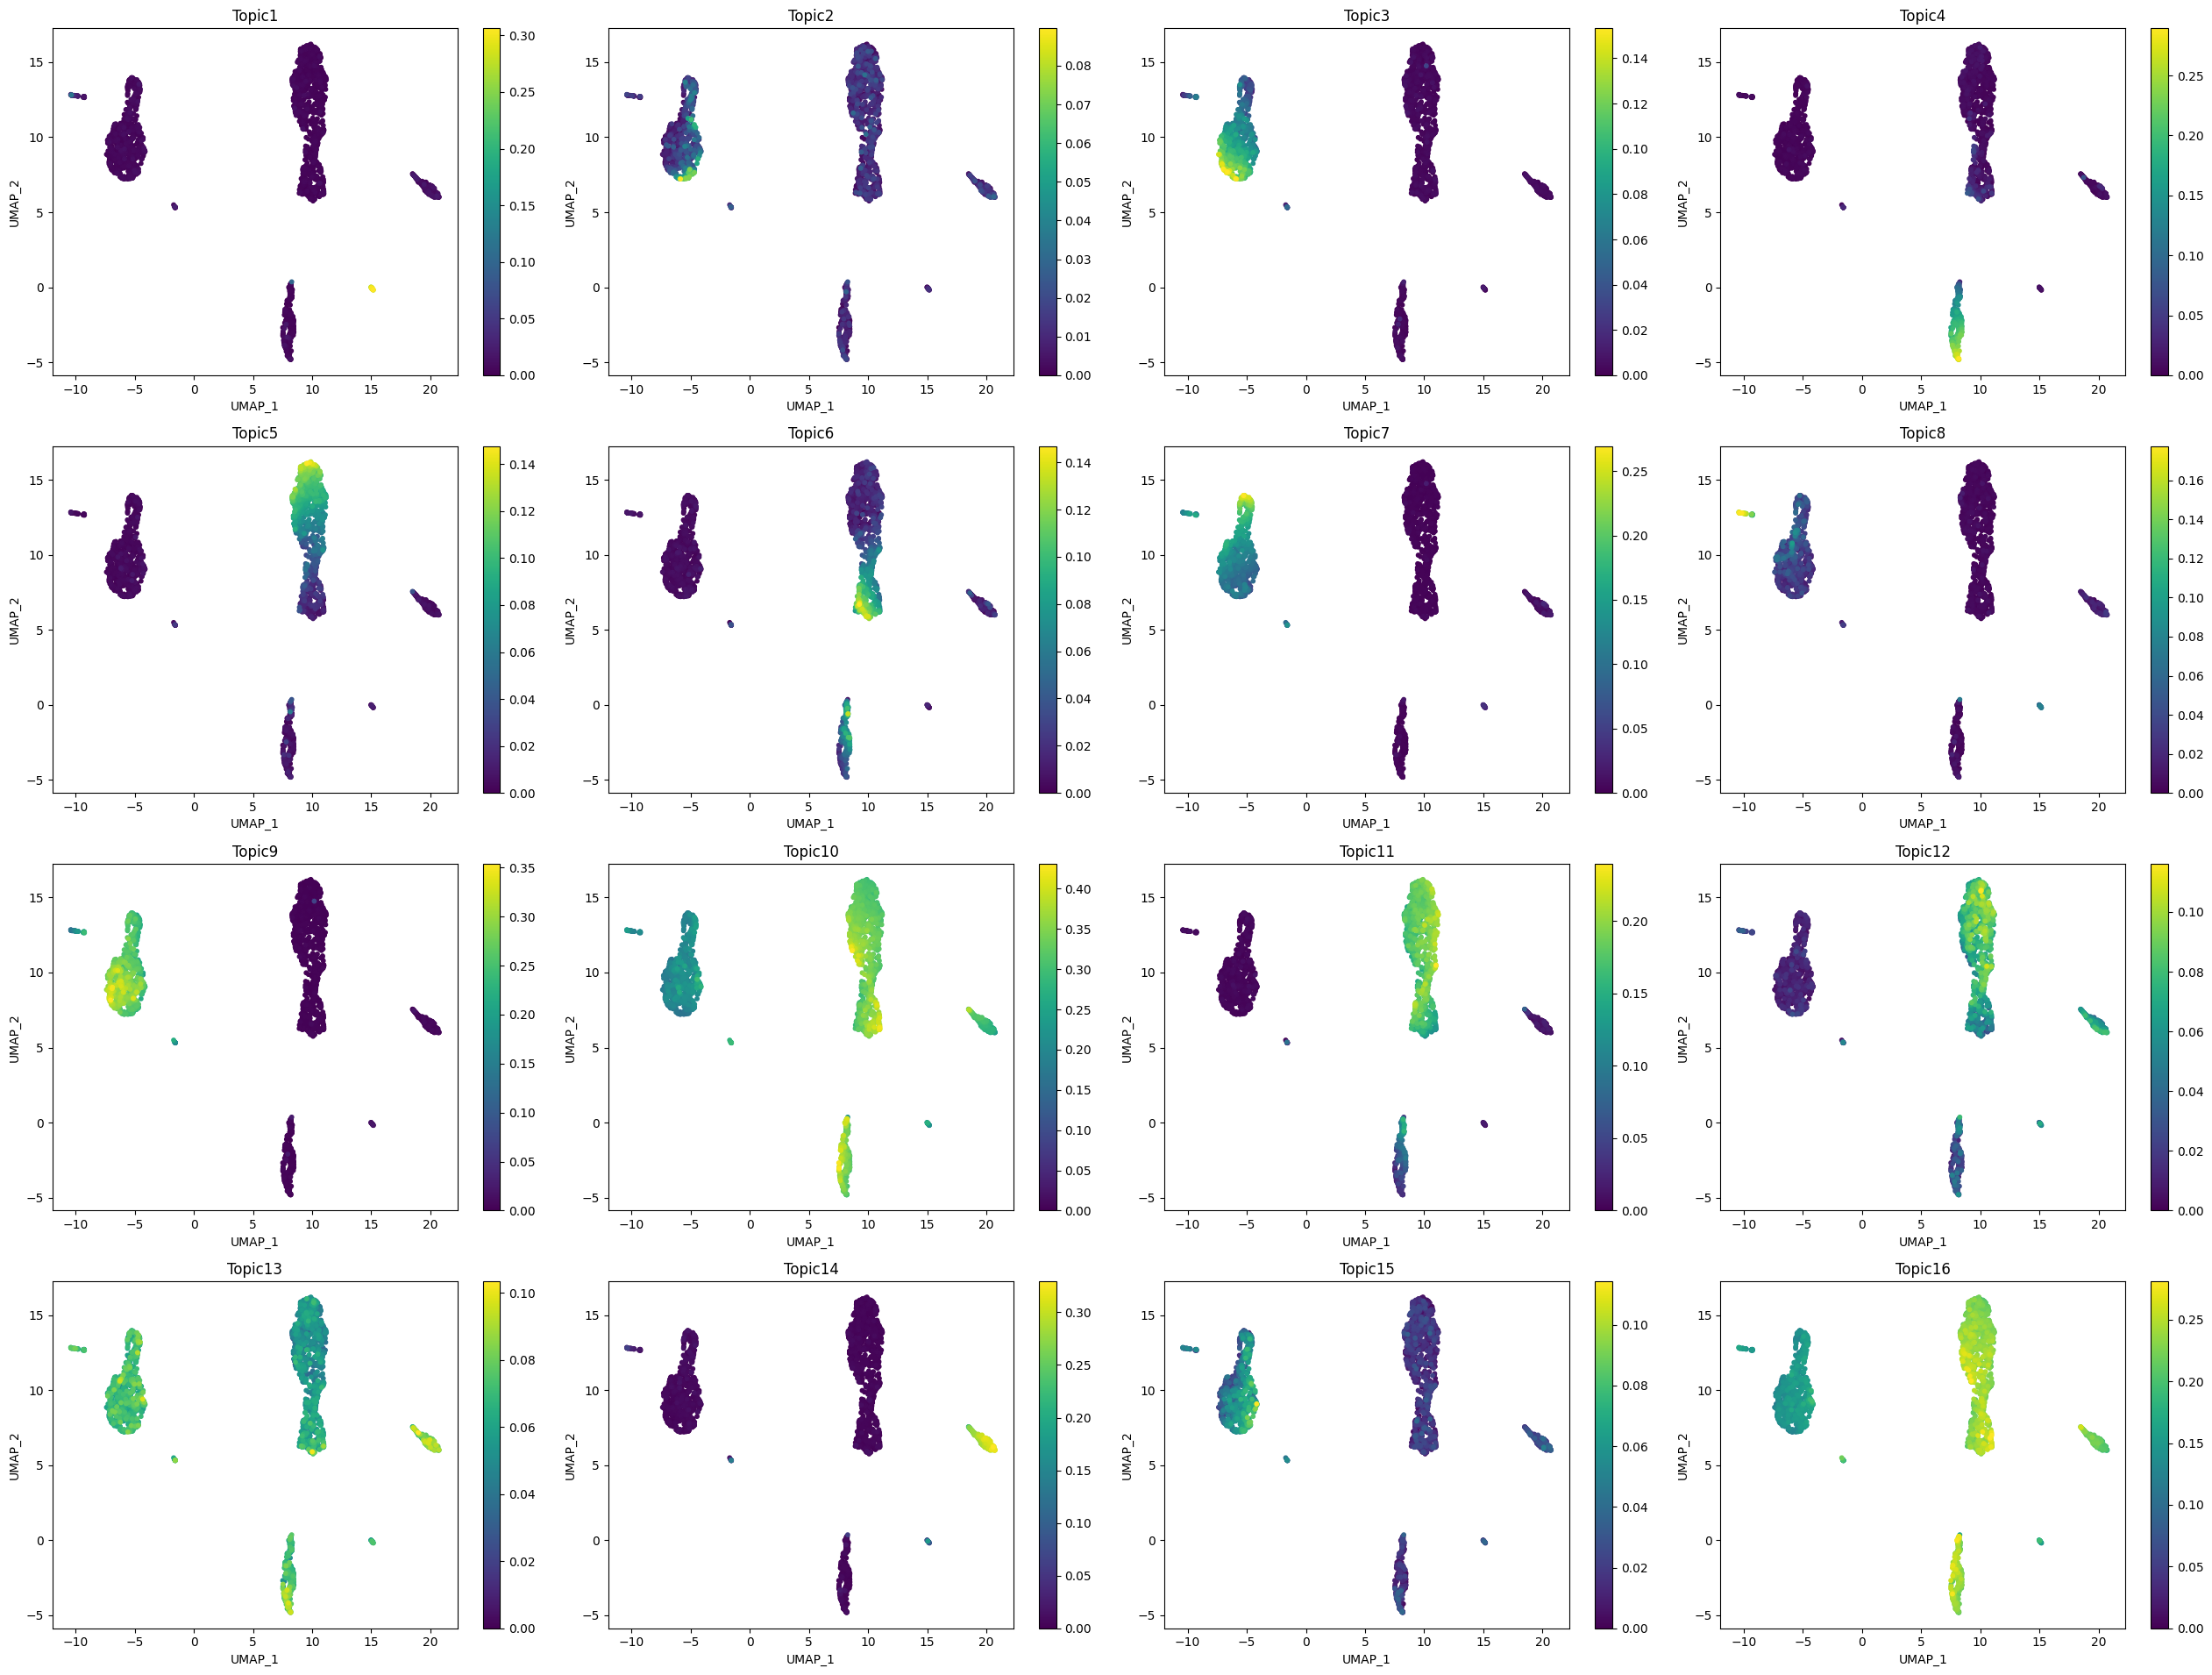

In [15]:
plot_topic(cistopic_obj, reduction_name = 'UMAP', num_columns = 4)

In [16]:
from pycisTopic.topic_binarization import *
region_bin_topics_otsu = binarize_topics(cistopic_obj, method='otsu')
region_bin_topics_top3k = binarize_topics(cistopic_obj, method='ntop', ntop = 3000)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [17]:
from pycisTopic.diff_features import *
imputed_acc_obj = impute_accessibility(cistopic_obj, selected_cells=None, selected_regions=None, scale_factor=10**6)
normalized_imputed_acc_obj = normalize_scores(imputed_acc_obj, scale_factor=10**4)
variable_regions = find_highly_variable_features(normalized_imputed_acc_obj, plot = False)
markers_dict = find_diff_features(cistopic_obj, imputed_acc_obj, variable='celltype', var_features=variable_regions, split_pattern = '-')

2023-01-02 16:55:27,714 cisTopic     INFO     Imputing drop-outs
2023-01-02 16:55:29,853 cisTopic     INFO     Scaling
2023-01-02 16:55:31,415 cisTopic     INFO     Keep non zero rows
2023-01-02 16:55:33,201 cisTopic     INFO     Imputed accessibility sparsity: 0.4346661603222636
2023-01-02 16:55:33,201 cisTopic     INFO     Create CistopicImputedFeatures object
2023-01-02 16:55:33,202 cisTopic     INFO     Done!
2023-01-02 16:55:33,203 cisTopic     INFO     Normalizing imputed data
2023-01-02 16:55:44,985 cisTopic     INFO     Done!
2023-01-02 16:55:44,986 cisTopic     INFO     Calculating mean
2023-01-02 16:55:45,603 cisTopic     INFO     Calculating variance
2023-01-02 16:55:53,039 cisTopic     INFO     Done!
2023-01-02 16:55:53,768 cisTopic     INFO     Formatting data for B_cells_1
2023-01-02 16:55:55,434 cisTopic     INFO     Computing p-value for B_cells_1
2023-01-02 16:56:49,304 cisTopic     INFO     Computing log2FC for B_cells_1
2023-01-02 16:56:50,824 cisTopic     INFO     B

<Figure size 640x480 with 0 Axes>

In [18]:
if not os.path.exists(os.path.join(work_dir, 'scATAC/candidate_enhancers')):
    os.makedirs(os.path.join(work_dir, 'scATAC/candidate_enhancers'))
import pickle
pickle.dump(region_bin_topics_otsu, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_otsu.pkl'), 'wb'))
pickle.dump(region_bin_topics_top3k, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_top3k.pkl'), 'wb'))
pickle.dump(markers_dict, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/markers_dict.pkl'), 'wb'))